# *Bag of visual words*

Experimentos para construir un "[vocabulario visual](https://en.wikipedia.org/wiki/Bag-of-words_model_in_computer_vision)".

## Bibliotecas y funciones auxiliares

In [1]:
import numpy             as np
import cv2               as cv
import matplotlib.pyplot as plt
import glob
import pickle

%matplotlib inline

def fig(w,h):
    plt.figure(figsize=(w,h))

def readrgb(file):
    return cv.cvtColor( cv.imread("../images/"+file), cv.COLOR_BGR2RGB) 
    
import glob
def readfiles(path):
    return [readrgb(file) for file in sorted(glob.glob('../images/'+path))]

## wikiart

Nuestro objetivo en este caso de estudio es identificar pinturas de Velázquez a partir de fragmentos. La página web [wikiart](https://www.wikiart.org/) proporciona imágenes de gran calidad que podemos descargar mediante la utilidad [wikiart retriever](https://github.com/lucasdavid/wikiart).

In [2]:
imgs = readfiles('velazquez/*/*.jpg')
print(len(imgs))

133


Las imágenes se caracterizarán mediante sus puntos SIFT:

1059


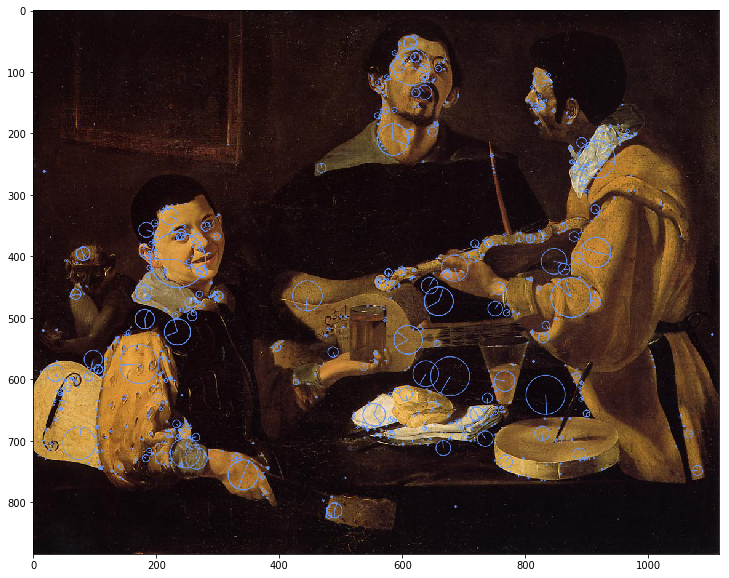

In [3]:
sift = cv.xfeatures2d.SIFT_create(nfeatures=0, contrastThreshold = 0.07)

img = imgs[5]

view = img.copy()

kp,desc = sift.detectAndCompute(img, mask=None)

flag = cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
cv.drawKeypoints(view,kp,view, color=(100,150,255), flags=flag)

fig(15,10)
print(len(kp))
plt.imshow(view);

Lo primero que hacemos es calcular los descriptores SIFT de toda la colección y guardarlos en memoria, de modo que en lo sucesivo podamos recuperarlos rápidamente. Guardamos los de cada imagen por separado en `allpoints`, y la colección completa en el array `points`. (Es redundante, pero así ilustramos la forma de trabajar con `pickle` y con `np.save_compressed`).

In [4]:
def mkSIFT(nfeatures=0, contrastThreshold=0.04, minscale=0):
        sift = cv.xfeatures2d.SIFT_create(nfeatures=nfeatures, contrastThreshold = contrastThreshold)
        def fun(x):
            kp,desc = sift.detectAndCompute(x, mask=None)
            sc = np.array([k.size for k in kp])
            return desc[sc>minscale].astype(np.uint8)
        return fun


sift = mkSIFT(contrastThreshold = 0.07)

if False:
    allpoints = []
    for k,x in enumerate(imgs):
        allpoints.append(sift(x))
        print(k, len(allpoints[-1]))

    pickle.dump( allpoints, open( "allpoints.p", "wb" ) )
    points = np.vstack(allpoints)
    np.savez_compressed('keypoints', points=points)
    
else:
    allpoints = pickle.load( open( "../data/allpoints.p", "rb" ) )
    points = np.load('../data/keypoints.npz')['points'].astype(np.float32)

points.shape, points.dtype

((191676, 128), dtype('float32'))

Por curiosidad, mostramos la distribución de simulitudes de un cierto punto con todos los demás.

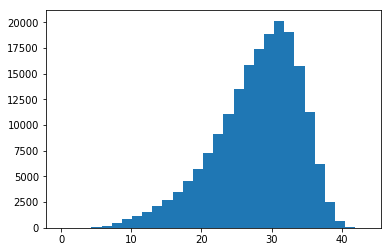

In [5]:
dis = abs(points - points[2334]).sum(axis=1)/128

plt.hist(dis,bins=30);# plt.ylim(0,200)

## *Matching* "normal" 

En primer lugar vamos a intentar reconocer las obras mediante el número de coincidencias "buenas", igual que en ejemplo simple del notebook [keypoints](keypoints.ipynb).

In [6]:
bf = cv.BFMatcher()

# número de coincidencias que superan el ratio test
def match(query, model):
    matches = bf.knnMatch(query,model,k=2)
    # ratio test
    good = []
    for m in matches:
        if len(m) == 2:
            best, second = m
            if best.distance < 0.75*second.distance:
                good.append(best)
    return len(good)

# devuelve una lista ordenada de número de matchings-índice del modelo
def find(x):
    v = sift(x)
    print(len(v))
    dists = sorted([(match(v,u),k) for k,u in enumerate(allpoints)])[::-1]
    return dists

Por ejemplo, la primera obra coincide con ella misma en 151 puntos, con la de índice 29 solo en 13, etc.

In [7]:
find(imgs[0])[:20]

151


[(151, 0),
 (13, 29),
 (12, 117),
 (12, 12),
 (10, 91),
 (9, 26),
 (9, 13),
 (9, 11),
 (8, 94),
 (8, 46),
 (8, 30),
 (8, 24),
 (7, 132),
 (7, 104),
 (7, 71),
 (7, 65),
 (7, 47),
 (7, 45),
 (7, 15),
 (6, 122)]

Hemos preparado unos cuantos recortes de algunas obras para probar el método.

In [19]:
cosas = readfiles('sift/1640/*.*')

La primera de ellas tiene 654 puntos SIFT, de los cuales coinciden 539 con el modelo 86, y el resto de modelos tiene muchas menos.

In [20]:
find(cosas[0])[:10]

654


[(539, 86),
 (23, 94),
 (19, 123),
 (19, 85),
 (19, 81),
 (19, 13),
 (17, 132),
 (16, 80),
 (16, 14),
 (15, 29)]

Vamos aponerlo más difícil, rotando, reduciendo de tamaño y suavizando el fragmento:

35
17 - 2
CPU times: user 2.65 s, sys: 43.7 ms, total: 2.7 s
Wall time: 754 ms


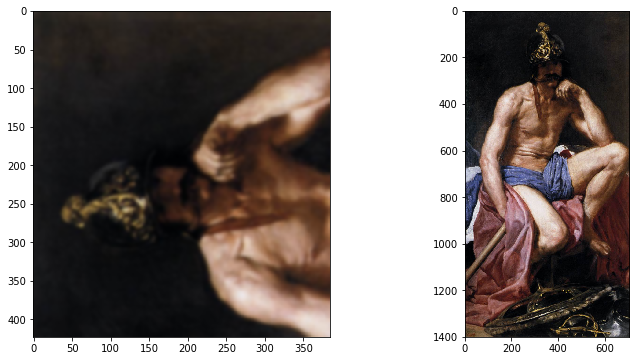

In [21]:
%%time

k = 2
b = 0
fig(12,6)
plt.subplot(1,2,1)
orig = cosas[k]
obs  = np.rot90(cv.GaussianBlur(cv.resize(orig,(0,0), fx=0.7, fy=0.7),(0,0), 2),1)
plt.imshow(obs);
dists = find(obs)[:5]
print(f'{dists[0][0]} - {dists[1][0]}')
best = dists[b][1]
plt.subplot(1,2,2)
plt.imshow(imgs[best]);

La evaluación es muy rápida debido a que en este caso en la imagen desconocida hay pocos puntos SIFT (35), de los cuales 17 coinciden con un modelo, que resulta ser correcto. El segundo mejor solo tiene 2 coincidencias.

Cuando la imagen tiene más puntos el tiempo de cómputo empieza a ser elevado:

1681
573 - 86
CPU times: user 1min 26s, sys: 372 ms, total: 1min 27s
Wall time: 22.2 s


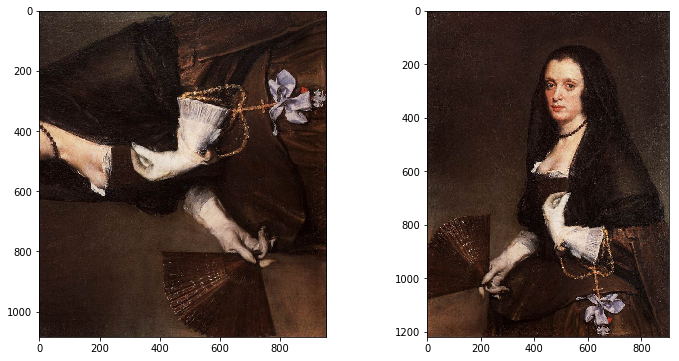

In [24]:
%%time

k = 8
b = 0
fig(12,6)
plt.subplot(1,2,1)
orig = cosas[k]
obs  = np.rot90(cv.GaussianBlur(cv.resize(orig,(0,0), fx=1.2, fy=1.2),(0,0), 0.1),1)
plt.imshow(obs);
dists = find(obs)[:5]
print(f'{dists[0][0]} - {dists[1][0]}')
best = dists[b][1]
plt.subplot(1,2,2)
plt.imshow(imgs[best]);

## k-means

Para intentar acelerar el tiempo de detección vamos a construir un "vocabulario visual" agrupando los puntos SIFT en un conjunto de, por ejemplo, 500 tipos. 

In [25]:
from sklearn.cluster import KMeans
from sklearn.externals import joblib

El proceso require varios minutos (dependiendo del ordenador, del número de puntos y de categorías puede superar media hora), por lo que lo almacenamos.

In [26]:
%%time

if False:
    #codebook = KMeans(n_clusters=500, random_state=0).fit(points[np.random.choice(len(points), 100000)])
    codebook = KMeans(n_clusters=500, random_state=0).fit(points)
    joblib.dump(codebook, 'codebook.pkl')
else:
    codebook = joblib.load('../data/codebook.pkl')

CPU times: user 0 ns, sys: 3.93 ms, total: 3.93 ms
Wall time: 12.5 ms


Los descriptores de cada punto SIFT se sustituyen por la etiqueta del *cluster* más próximo:

In [27]:
codebook.predict(sift(imgs[1]))

array([ 38,  38, 302, ..., 448, 155, 478], dtype=int32)

Por curiosidad, mostramos la distribución de distancias de cada punto a su cluster.

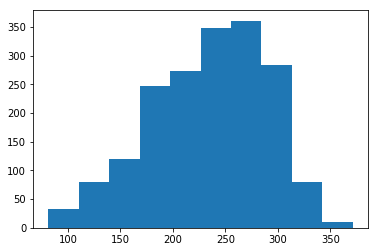

In [15]:
desc = sift(imgs[1])
index = codebook.predict(desc)
r = codebook.cluster_centers_[index] - desc
d = np.sqrt((r**2).sum(axis=1))
plt.hist(d);

Las imágenes se representarán mediante el histograma de códigos de descriptores. (Teniendo en cuenta solo aquellos que están suficientemente cerca del cluster asignado. No está claro si esto tiene influencia positiva.)

In [29]:
def getcode(x):
    desc = sift(x)
    index = codebook.predict(desc)
    r = codebook.cluster_centers_[index] - desc
    d = np.sqrt((r**2).sum(axis=1))
    return np.histogram(index[d<250],np.arange(codebook.n_clusters+1))[0]

Veamos el histograma de un par de imágenes:

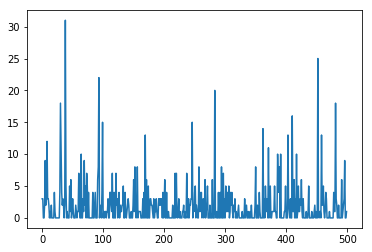

In [30]:
plt.plot(getcode(imgs[1]));

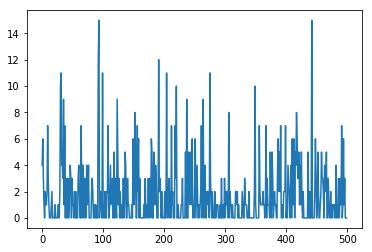

In [31]:
plt.plot(getcode(imgs[35]));

Calculamos los histogramas de toda la colección y los almacenamos.

In [32]:
%%time

if False:
    imagecodes = [getcode(x) for x in imgs]
    pickle.dump( imagecodes, open( "imagecodes.p", "wb" ) )
else:
    imagecodes = pickle.load( open( "../data/imagecodes.p", "rb" ) )

CPU times: user 2.02 ms, sys: 0 ns, total: 2.02 ms
Wall time: 12.9 ms


Para comparar este tipo de histogramas la similitud la medimos con la suma de mínimos en cada caja (intersección). La idea es que para que haya una coincidencia, los puntos deberían ir a la misma caja del histograma. Se normaliza el valor con el número total de puntos, intentando potenciar que se cubra lo más posible el modelo.

In [34]:
def simil(u,v):
    t = max(u.sum(),v.sum())
    return np.minimum(u,v).sum()/t


def find(x):
    v = getcode(x)
    print(v.sum())
    dists = sorted([(simil(v,u),k) for k,u in enumerate(imagecodes)])[::-1]
    return dists

Como primera prueba, vemos la similitud de uno de los modelos con toda la colección. El mejor es él mismo, con similitud perfecta (1.0) y el siguiente queda muy lejos.

In [21]:
find(imgs[1])[:10]

1013


[(1.0, 1),
 (0.57726180944755801, 120),
 (0.57476635514018692, 49),
 (0.56762092793682128, 6),
 (0.56751467710371817, 119),
 (0.56495204882301653, 23),
 (0.56268509378084897, 69),
 (0.55478775913129319, 63),
 (0.54815974941268597, 77),
 (0.54563106796116501, 125)]

Esta misma información en forma de histograma:

1013


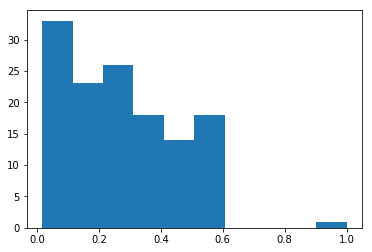

In [22]:
plt.hist([x[0] for x in find(imgs[1])]);

Sin embargo, cuando modificamos bastante la imagen, las distancias se igualan mucho. Y en este caso concreto la imagen correcta queda en posición 14...

0.0980392156863
30
30


[(0.20833333333333334, 12),
 (0.15789473684210525, 111),
 (0.15789473684210525, 30),
 (0.15476190476190477, 21),
 (0.14754098360655737, 25),
 (0.14084507042253522, 81),
 (0.1276595744680851, 94),
 (0.12380952380952381, 34),
 (0.11864406779661017, 13),
 (0.10975609756097561, 26),
 (0.1095890410958904, 47),
 (0.10576923076923077, 43),
 (0.10126582278481013, 65),
 (0.098039215686274508, 50),
 (0.094339622641509441, 89)]

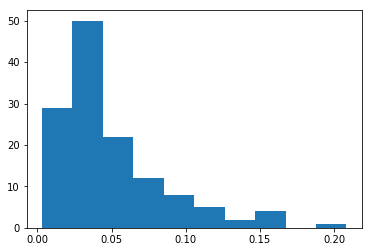

In [23]:
orig = imgs[50]
obs  = cv.GaussianBlur(cv.resize(orig,(0,0), fx=0.7, fy=0.7),(0,0), 2)
print(simil(getcode(orig),getcode(obs)))
dists = find(obs)
plt.hist([x[0] for x in dists])
find(obs)[:15]

La mayor similitud no siempre corresponde con el modelo correcto. Lo importante es que éste quede en las primeras posiciones, de modo que podamos aplicar la técnica de coincidencias más precisa sólo con los, p. ej. 20, mejores candidatos, en lugar de los más de 100 modelos de toda la colección.

311
0.56 - 0.44


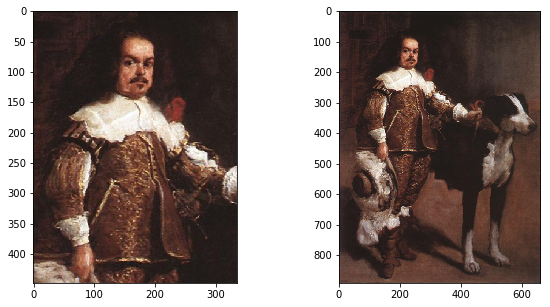

In [24]:
k = 0
b = 0
fig(10,5)
plt.subplot(1,2,1)
plt.imshow(cosas[k]);
dists = find(cosas[k])
print(f'{dists[0][0]:.2f} - {dists[1][0]:.2f}')
best = dists[b][1]
plt.subplot(1,2,2)
plt.imshow(imgs[best]);

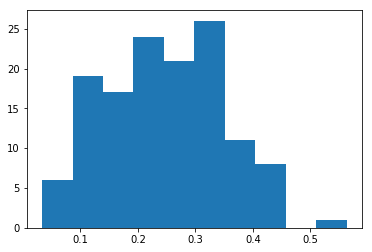

In [25]:
plt.hist([x[0] for x in dists]);

Pendiente:

- clasificación de categorías
- features para un clasificador (e.g. SVM)